# 필요한 라이브러리 불러오기

In [1]:
import os, natsort, glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# 시계열 데이터 분석을 위한 머신러닝 라이브러리
from tslearn.clustering import TimeSeriesKMeans

# 디렉토리 지정 및 데이터 불러오기

In [2]:
os.chdir('C:/Users/hjm01/Desktop/겨울방학/alfven/old_data')

name = 'helios1_1980.csv'
year = int(name[8:12])

year = int(name[8:12])
data = pd.read_csv(name,index_col="Time",parse_dates=True)[['v','alfvenicity2']]
data = data[data['v'] < 450]['alfvenicity2']
data = abs(pd.DataFrame(data))

columns = pd.date_range(str(year)+'/01/01 00:00',str(year)+'/12/31 18:00',freq="6H")
index = pd.timedelta_range(start='00:30:00', periods=12,freq='30T')

# 머신러닝을 적용하기 위해서 빈 데이터 프레임 설정
reshape_data = pd.DataFrame(index=index,columns=columns)

# 데이터 채워넣기 및 머신러닝 적용

In [3]:
# 빈 데이터 프레임에 머신러닝을 적용할 수 있게 데이터 채워넣기
j = 0 ; k = 0
for i in range(0,len(data.index)):
  while k <= len(index):
    if k == len(index):
      k = 0 ; j += 1
    elif columns[j] + index[k] == data.index[i]:
      reshape_data.iloc[k,j] = data.iloc[i]['alfvenicity2']
      k += 1
      break
    else:
      k += 1

In [4]:
# 빈 셀의 경우 보간법을 이용하여 채워넣기
reshape_data = reshape_data.astype('float').interpolate()
A = reshape_data.dropna(axis=1)

# 머신러닝을 이용하여 시계열 데이터 분류 (자동분류)
ks = TimeSeriesKMeans(n_clusters=2, metric='softdtw')
y_pred = ks.fit_predict(A.transpose())

# 원하는 형태로 뒤집어주기
B = A.transpose()
B['type'] = y_pred

# 분류 형태 파악을 위한 그림 그리기

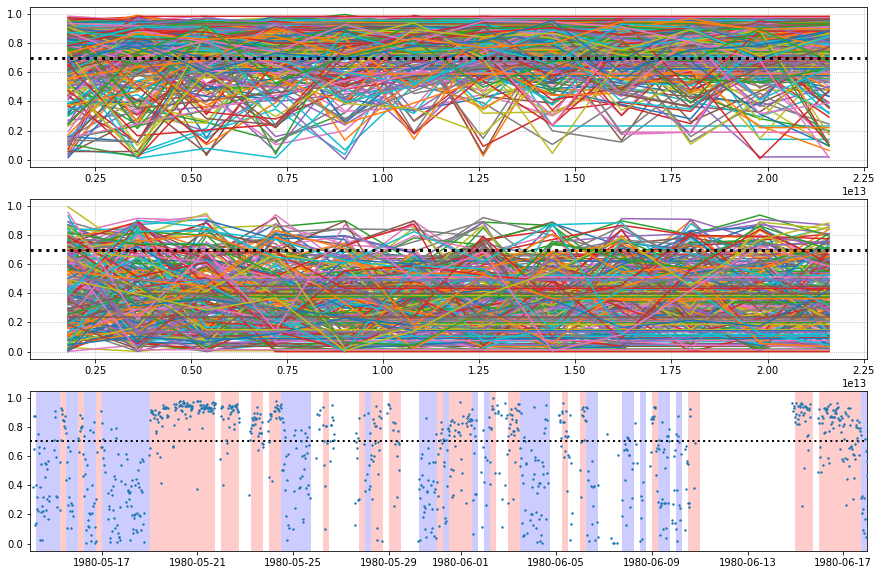

In [5]:
fig,ax = plt.subplots(3,1,sharex=False,sharey=True,figsize=(15,10))
for i in range(len(A.columns)):
  ax[y_pred[i]].plot(A.iloc[:,[i]])
  ax[y_pred[i]].grid(linestyle=":")
for i in [0,1]:
  ax[i].axhline(0.7,color='black',linestyle=':',linewidth=3)

zip_list = list(zip(B.index,B['type']))

hour = 6
for i,j in zip_list:
  if j == 0:
    ax[2].axvspan(i,i+timedelta(hours=hour),alpha=0.2,facecolor='red')
  elif j == 1:
    ax[2].axvspan(i,i+timedelta(hours=hour),alpha=0.2,facecolor='blue')
  else:
    pass

ax[2].scatter(data.index,data,s=2,zorder=10)
ax[2].axhline(0.7,color='black',linestyle=':',linewidth=2)
time = datetime(1980,5,14,0,0,0)
ax[2].set_xlim(time,time+timedelta(days=35))

plt.show()

- 빨강 : Alfvenicity 값이 높은 시계열 데이터
- 파랑 : Alfvenicity 값이 낮거나 섞여있는 시계열 데이터

1. Alfvenicity라는 변수는 0.7정도를 기점으로 나뉘는 것으로 확인 됨
2. 꽤 긴 시계열 데이터에 대해서 굉장히 잘 나눠진 모습을 볼 수 있음
3. 연구자에 따라 Alfvenicity는 다양하게 나뉘는데, 우리의 연구에선 0.7정도로 설정
4. 이는 이전에 연구했던 Wang et al.(2019)와 boundary가 비슷함